In [1]:
!pip3 install -q keras-cv
!pip3 install -qU tensorflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.82.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


## Imports

In [2]:
import glob
import os
import random
from pathlib import Path

import numpy as np
import tensorflow as tf
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
import keras_cv
import matplotlib.pyplot as plt
from tensorflow import keras

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


## Configuration

In [151]:
class CFG:
    seed = 77
    output_dir = '/kaggle/working/train'
    
    # model
    num_classes = 2
    neck_features = None
    
    # optmizer
    initial_lr = 5e-4
    lr_decay_type = 'exponential'
    steps_per_epoch = 1
    decay_factor = 0.97
    decay_epochs = 2.4
    warmup_epochs = 5
    minimal_lr = 0
    
    # loss
    label_smoothing = 0.1
    
    # dataset
    ds_root_dir = '/kaggle/input/cats-and-dogs-image-classification'
    image_size = (384, 384)
    batch_size = 42
    drop_remainder = False
    repeat = True
    shuffle = True
    val_split = 0.2
    
    # labels info
    labels = list(range(num_classes))
    class_names = ['cat', 'dog']
    label_to_name = {l: n for l, n in zip(labels, class_names)}
    name_to_label = {n: l for l, n in label_to_name.items()}

## Reproducibility ♻️


In [152]:
def seeding(seed=CFG.seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seeding(CFG.seed)

## Set up strategy and device

In [153]:
def get_device_and_strategy():
    gpus = tf.config.list_logical_devices('GPU')
    if gpus:
        if len(gpus) > 1:
            strategy = tf.distribute.MirroredStrategy(gpus)
        else:
            strategy = tf.distribute.OneDeviceStrategy(gpus[0])
        device = 'GPU'
    else:
        strategy = tf.distribute.OneDeviceStrategy('CPU')
        device = 'CPU'
    return strategy, device

In [154]:
strategy, device = get_device_and_strategy()
print('running on {}, num devices: {}'.format(device, strategy.num_replicas_in_sync))

running on GPU, num devices: 1


## Data Loaders

### Decoder

In [155]:
def decoder(with_labels=True, image_size=CFG.image_size, num_classes=CFG.num_classes):
    def decode_image(image_path):
        file_bytes = tf.io.read_file(image_path)
        image_path = Path(str(image_path))
        if image_path.suffix == '.png':
            image = tf.image.decode_png(file_bytes, channels=3)
        elif image_path.suffix in ['.jpg', '.jpeg']:
            image = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            image = tf.image.decode_image(file_bytes, channels=3, expand_animations=False)
        image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
        return image
    
    def decode_label(label):
        label = tf.one_hot(label, num_classes)
        label = tf.cast(label, tf.float32)
        return label
    
    def decode(image_path):
        image = decode_image(image_path)
        image = tf.image.resize_with_pad(image, *image_size)
        image = tf.keras.applications.efficientnet.preprocess_input(image)
        return image
        
    def decode_with_labels(image_path, label):
        image = decode(image_path)
        label = decode_label(label)
        return image, label
    
    return decode_with_labels if with_labels else decode

### Augmenter

In [156]:
def augmenter(with_labels=True):
    augs = tf.keras.Sequential(
               layers=[
                   keras_cv.layers.RandomBrightness(0.1),
                   keras_cv.layers.RandomContrast(0.1),
                   keras_cv.layers.RandomHue(0.1, (0, 255)),
                   keras_cv.layers.RandomRotation(0.1),
                   keras_cv.layers.RandomSharpness(0.1, (0, 255)),
                   keras_cv.layers.RandomFlip(),
                   keras_cv.layers.RandAugment(value_range=(0, 255)),
                ]
            )
    
    def augment(images):
        fake_labels = tf.zeros(images.shape[0])
        inputs = {'images': images, 'labels': fake_labels}
        return augs(inputs)['images']
        
    def augment_with_labels(images, labels):
        inputs = {'images': images, 'labels': labels}
        augmented = augs(inputs)
        return augmented['images'], augmented['labels']
        
    return augment_with_labels if with_labels else augment

## Data pipeline

In [157]:
def build_dataset(image_paths, 
                  labels=None,
                  decode_fn=None,
                  augment=True,
                  augment_fn=None, 
                  batch_size=CFG.batch_size, 
                  drop_remainder=CFG.drop_remainder, 
                  repeat=CFG.repeat, 
                  shuffle=CFG.shuffle,
                  seed=CFG.seed,
                 ):
    if decode_fn is None:
        decode_fn = decoder(labels is not None)
    if augment and augment_fn is None:
        augment_fn = augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
    
    slices = image_paths if labels is None else (image_paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.repeat() if repeat else ds
    
    opt = tf.data.Options()
    if shuffle:
        ds = ds.shuffle(shuffle, seed=seed)
        opt.experimental_deterministic = True
        
    ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Data paths

In [158]:
ds_root_dir = Path(CFG.ds_root_dir)

train_cats_paths = glob.glob(str(ds_root_dir / 'train' / 'cats' / '*'))
train_dogs_paths = glob.glob(str(ds_root_dir / 'train' / 'dogs' / '*'))

test_cats_paths = glob.glob(str(ds_root_dir / 'test' / 'cats' / '*'))
test_dogs_paths = glob.glob(str(ds_root_dir / 'test' / 'dogs' / '*'))

train_image_paths = train_cats_paths + train_dogs_paths
train_labels = [CFG.name_to_label['cat']] * len(train_cats_paths) + \
               [CFG.name_to_label['dog']] * len(train_dogs_paths)

test_image_paths = test_cats_paths + test_dogs_paths
test_labels = [CFG.name_to_label['cat']] * len(test_cats_paths) + \
              [CFG.name_to_label['dog']] * len(test_dogs_paths)

# shuffle
rng = np.random.default_rng(CFG.seed)
train_index = np.arange(len(train_image_paths))
test_index = np.arange(len(test_image_paths))
rng.shuffle(train_index)
rng.shuffle(test_index)

train_image_paths = np.array(train_image_paths)[train_index]
train_labels = np.array(train_labels)[train_index]

test_image_paths = np.array(test_image_paths)[test_index]
test_labels = np.array(test_labels)[test_index]

# train, val split
num_val_samples = int(len(train_image_paths) * CFG.val_split)

train_image_paths = train_image_paths[num_val_samples:]
train_labels = train_labels[num_val_samples:]

val_image_paths = train_image_paths[:num_val_samples]
val_labels = train_labels[:num_val_samples]

print('train ds size: ', len(train_image_paths))
print('val ds size: ', len(val_image_paths))
print('test ds size: ', len(test_image_paths))

train ds size:  446
val ds size:  111
test ds size:  140


## Visualization

In [159]:
def plot_batch(batch, row=3, col=3):
    if isinstance(batch, tuple) or isinstance(batch, list):
        imgs, labels = batch
    else:
        imgs = batch
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        ax.imshow(imgs[idx])
        if labels is not None:
            label = labels[idx].numpy().argmax()
            name = CFG.label_to_name[label]
            plt.title(name)
    plt.show()

#### Without augmentations

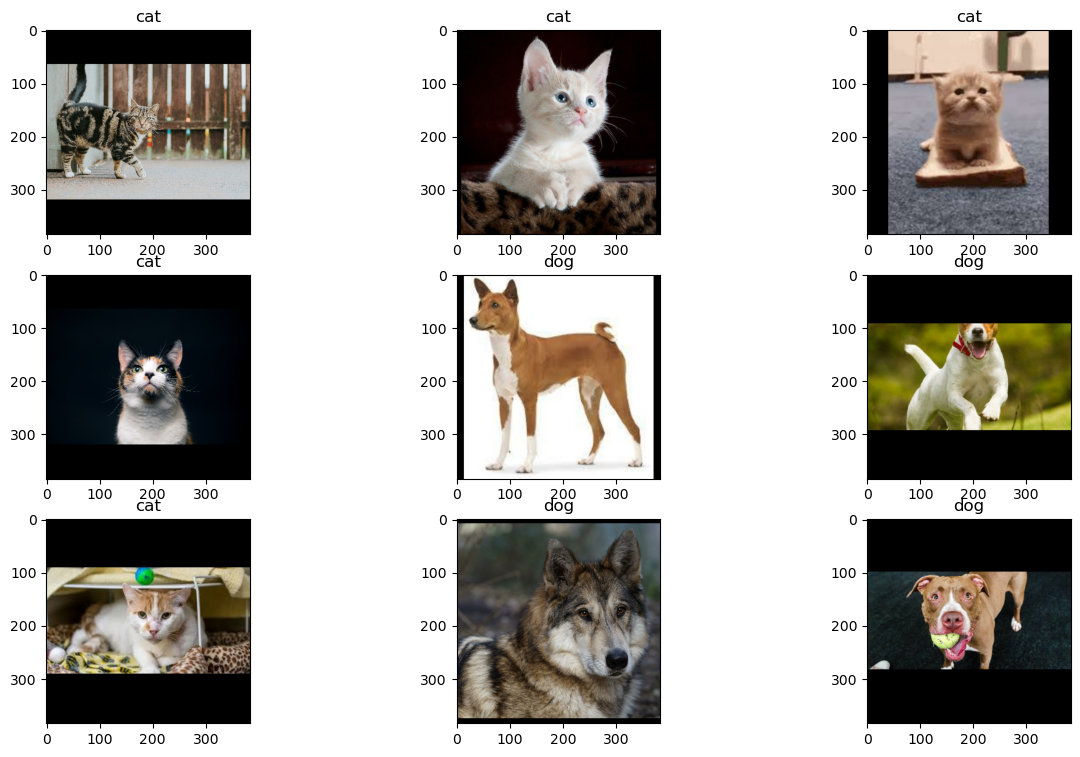

In [160]:
vis_ds_no_aug = build_dataset(train_image_paths[:9], labels=train_labels[:9], augment=False)
imgs, labels = next(iter(vis_ds_no_aug))
imgs = tf.cast(imgs, tf.uint8)
plot_batch((imgs, labels))

### With augmentations

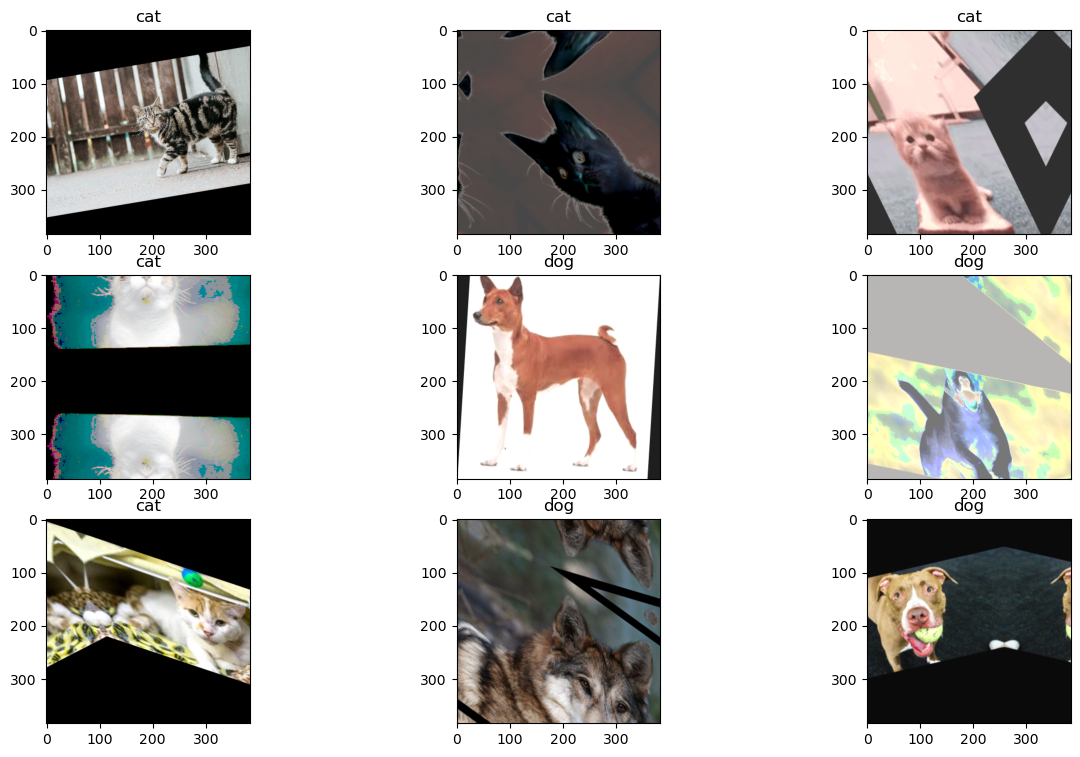

In [161]:
vis_ds_with_aug = build_dataset(train_image_paths[:9], labels=train_labels[:9], augment=True)
imgs, labels = next(iter(vis_ds_with_aug))
imgs = tf.cast(imgs, tf.uint8)
plot_batch((imgs, labels))

## Modeling

In [162]:
def get_model(num_classes=CFG.num_classes, 
              input_shape=CFG.image_size, 
              neck_features=CFG.neck_features, 
              weights=None
             ):
    backbone = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, 
                                                                 weights='imagenet', 
                                                                 input_shape=(*input_shape, 3))
    
    inputs = tf.keras.layers.Input(shape=(*input_shape, 3))
    
    out = backbone(inputs)
    
    out = tf.keras.layers.GlobalAveragePooling2D()(out)
    
    if neck_features is not None:
        out = tf.keras.layers.Dense(neck_features, activation='selu')(out)
        
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(out)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    
    if weights is not None:
        model.load_weights(weights)
        
    return model

In [163]:
model = get_model()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 12, 12, 1280)     4049571   
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


## Compile model

In [164]:
# from https://github.com/google/automl/blob/master/efficientnetv2/utils.py
class WarmupLearningRateSchedule(
        tf.keras.optimizers.schedules.LearningRateSchedule):
    """Provides a variety of learning rate decay schedules with warm up."""

    def __init__(self,
                 initial_lr,
                 steps_per_epoch=None,
                 lr_decay_type='exponential',
                 decay_factor=0.97,
                 decay_epochs=2.4,
                 total_steps=None,
                 warmup_epochs=5,
                 minimal_lr=0):
        super(WarmupLearningRateSchedule, self).__init__()
        self.initial_lr = initial_lr
        self.steps_per_epoch = steps_per_epoch
        self.lr_decay_type = lr_decay_type
        self.decay_factor = decay_factor
        self.decay_epochs = decay_epochs
        self.total_steps = total_steps
        self.warmup_epochs = warmup_epochs
        self.minimal_lr = minimal_lr

    def __call__(self, step):
        if self.lr_decay_type == 'exponential':
            assert self.steps_per_epoch is not None
            decay_steps = self.steps_per_epoch * self.decay_epochs
            lr = tf.keras.optimizers.schedules.ExponentialDecay(
                self.initial_lr,
                decay_steps,
                self.decay_factor,
                staircase=True)(step)
        elif self.lr_decay_type == 'cosine':
            assert self.total_steps is not None
            lr = 0.5 * self.initial_lr * (1 + tf.cos(
                np.pi * tf.cast(step, tf.float32) / self.total_steps))
        elif self.lr_decay_type == 'linear':
            assert self.total_steps is not None
            lr = (1.0 - tf.cast(step, tf.float32) /
                  self.total_steps) * self.initial_lr
        elif self.lr_decay_type == 'constant':
            lr = self.initial_lr
        else:
            assert False, 'Unknown lr_decay_type : %s' % self.lr_decay_type

        if self.minimal_lr:
            lr = tf.math.maximum(lr, self.minimal_lr)

        if self.warmup_epochs:
            warmup_steps = int(self.warmup_epochs * self.steps_per_epoch)
            warmup_lr = (self.initial_lr * tf.cast(step, tf.float32) /
                         tf.cast(warmup_steps, tf.float32))
            lr = tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: lr)

        return lr

    def get_config(self):
        return {
            'initial_lr': self.initial_lr,
            'steps_per_epoch': self.steps_per_epoch,
            'lr_decay_type': self.lr_decay_type,
            'decay_factor': self.decay_factor,
            'decay_epochs': self.decay_epochs,
            'total_steps': self.total_steps,
            'warmup_epochs': self.warmup_epochs,
            'minimal_lr': self.minimal_lr,
        }

In [165]:
optimizer = tf.keras.optimizers.Adam(learning_rate=WarmupLearningRateSchedule(CFG.initial_lr,
                                                                              lr_decay_type=CFG.lr_decay_type,
                                                                              steps_per_epoch=CFG.steps_per_epoch,
                                                                              decay_factor=CFG.decay_factor,
                                                                              decay_epochs=CFG.decay_epochs,
                                                                              warmup_epochs=CFG.warmup_epochs,
                                                                              minimal_lr=CFG.minimal_lr))

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=CFG.label_smoothing or 0.0)

metrics = [
    tf.keras.metrics.AUC(curve='PR', name='auc'),
    tf.keras.metrics.CategoricalAccuracy()
]

In [166]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

## Training

In [167]:
epochs = 30

train_ds = build_dataset(train_image_paths, train_labels, augment=True, repeat=False)
val_ds = build_dataset(val_image_paths, val_labels, augment=False, repeat=False)

output_dir = Path(CFG.output_dir)
if not output_dir.is_dir():
    output_dir.mkdir(parents=True)
    
checkpoints_path = output_dir / 'checkpoints'
tensorboard_logs_dir = output_dir / 'tensorboard_logs'

# in tf 2.11.0 ModelCheckpoint doesn't work for me :(
callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(str(checkpoints_path),
#                                        monitor='val_auc',
#                                        save_best_only=True),
    tf.keras.callbacks.TensorBoard(str(tensorboard_logs_dir))
]

history = model.fit(train_ds,
              callbacks=callbacks,
              validation_data=val_ds,
              epochs=epochs)

model.save_weights(str(checkpoints_path / 'lst_checkpoint'))

Epoch 1/30


2023-04-03 15:08:56.783331: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11/11 [==============================] - 70s 2s/step - loss: 0.5601 - auc: 0.8224 - categorical_accuracy: 0.7332 - val_loss: 0.2904 - val_auc: 1.0000 - val_categorical_accuracy: 1.0000
Epoch 2/30
11/11 [==============================] - 34s 3s/step - loss: 0.3709 - auc: 0.9701 - categorical_accuracy: 0.9058 - val_loss: 0.3789 - val_auc: 0.9992 - val_categorical_accuracy: 0.9910
Epoch 3/30
11/11 [==============================] - 35s 3s/step - loss: 0.3362 - auc: 0.9816 - categorical_accuracy: 0.9305 - val_loss: 0.2645 - val_auc: 0.9996 - val_categorical_accuracy: 0.9910
Epoch 4/30
11/11 [==============================] - 34s 3s/step - loss: 0.3186 - auc: 0.9862 - categorical_accuracy: 0.9372 - val_loss: 0.2640 - val_auc: 1.0000 - val_categorical_accuracy: 1.0000
Epoch 5/30
11/11 [==============================] - 35s 3s/step - loss: 0.2979 - auc: 0.9899 - categorical_accuracy: 0.9641 - val_loss: 0.2440 - val_auc: 1.0000 - val_categorical_accuracy: 1.0000
Epoch 6/30
11/11 [=============

## Testing

In [168]:
test_ds = build_dataset(test_image_paths, test_labels, augment=False, repeat=False)

_ = model.evaluate(test_ds)

num_fails = 0
for i, (imgs, labels) in enumerate(test_ds):
    preds = model(imgs)
    idxs = tf.argmax(preds, axis=1)
    probs = tf.gather(preds, idxs, axis=1, batch_dims=1)
    labels = tf.argmax(labels, axis=1) # decode one hot labels
    num_fails += int(tf.reduce_sum(tf.cast(idxs != labels, tf.float32)))

print('num fails: {} / {}'.format(num_fails, len(test_image_paths)))

4/4 [==============================] - 1s 263ms/step - loss: 0.3195 - auc: 0.9579 - categorical_accuracy: 0.9571
num fails: 6 / 140
